In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import shutil


In [2]:

data = pd.read_csv("test_assignment_sim.csv")
site_co = pd.read_csv("site_coordinates.csv")

sites_datas = []
for i in range(49):
    slice = data.iloc[:,[0,1,2,3]].copy()
    slice['thickness'] = data.iloc[:,i+4]
    slice['SITE'] = i # in lgb, catagory should be a int
    slice['S_X'] = site_co['SITE_X'][i]
    slice['S_Y'] = site_co['SITE_Y'][i]
    sites_datas.append(slice)

# %%
site_thickness = sites_datas[0]
for j in range(1,49):
    site_thickness = pd.concat([site_thickness,sites_datas[j]])

clist = list(site_thickness.columns)
clist.append(clist.pop(4))
clist.pop(4)
site_thickness = site_thickness[clist]
site_thickness.reset_index(drop=True)
site_thickness['TOOL'] = site_thickness['TOOL'].astype('category')
site_thickness.head(15)


,FLOWFACTOR,SPACING,DEP TIME,TOOL,S_X,S_Y,thickness
0,0.916,0.344,69.289,1,-49000.0,6.000570e-12,1601.802686
1,0.916,0.344,69.289,2,-49000.0,6.000570e-12,1516.411140
2,0.916,0.344,69.289,3,-49000.0,6.000570e-12,1478.098433
3,0.916,0.344,69.289,4,-49000.0,6.000570e-12,1550.290615
4,0.957,0.348,70.253,1,-49000.0,6.000570e-12,1544.883218
5,0.957,0.348,70.253,2,-49000.0,6.000570e-12,1489.344728
6,0.957,0.348,70.253,3,-49000.0,6.000570e-12,1493.257169
7,0.957,0.348,70.253,4,-49000.0,6.000570e-12,1532.502760
8,0.958,0.346,67.731,1,-49000.0,6.000570e-12,1510.842000
9,0.958,0.346,67.731,2,-49000.0,6.000570e-12,1459.394993


In [3]:
thickness_dmy = pd.get_dummies(site_thickness)
thickness_dmy.head(15)

,FLOWFACTOR,SPACING,DEP TIME,S_X,S_Y,thickness,TOOL_1,TOOL_2,TOOL_3,TOOL_4
0,0.916,0.344,69.289,-49000.0,6.000570e-12,1601.802686,1,0,0,0
1,0.916,0.344,69.289,-49000.0,6.000570e-12,1516.411140,0,1,0,0
2,0.916,0.344,69.289,-49000.0,6.000570e-12,1478.098433,0,0,1,0
3,0.916,0.344,69.289,-49000.0,6.000570e-12,1550.290615,0,0,0,1
4,0.957,0.348,70.253,-49000.0,6.000570e-12,1544.883218,1,0,0,0
5,0.957,0.348,70.253,-49000.0,6.000570e-12,1489.344728,0,1,0,0
6,0.957,0.348,70.253,-49000.0,6.000570e-12,1493.257169,0,0,1,0
7,0.957,0.348,70.253,-49000.0,6.000570e-12,1532.502760,0,0,0,1
8,0.958,0.346,67.731,-49000.0,6.000570e-12,1510.842000,1,0,0,0
9,0.958,0.346,67.731,-49000.0,6.000570e-12,1459.394993,0,1,0,0


In [4]:


dftrain,dftest = train_test_split(thickness_dmy,test_size=0.1)

#normallize data
mean = dftrain.mean()
std = dftrain.std()
train_data = (dftrain - mean) / std


dftrain,dfval = train_test_split(train_data,test_size = 0.11)

In [5]:


# %%
shutil.rmtree('lab2-logs',ignore_errors=True)
model = keras.Sequential(name='model-1')

model.add(layers.Dense(18, use_bias=False, input_shape=(9,)))
model.add(layers.LeakyReLU())
model.add(layers.Dense(36))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(18))
model.add(layers.LeakyReLU())

model.add(layers.Dense(1))
model.summary()
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanSquaredError()])
# path of the model
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
#store the best one
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',monitor='val_loss',save_best_only=True,mode='min')
#training
history = model.fit(dftrain.drop(['thickness'],axis=1), dftrain['thickness'],batch_size=30,epochs=40,validation_data=(dfval.drop(['thickness'],axis=1), dfval['thickness']),callbacks=[model_cbk, model_mckp]) 
# %%



Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                162       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                684       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36)                0         
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                666       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 18)                0   

19624/19624 [==============================] - 2s 121us/sample - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0768 - val_mean_squared_error: 0.0768
Epoch 40/40
19624/19624 [==============================] - 3s 132us/sample - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0603 - val_mean_squared_error: 0.0603


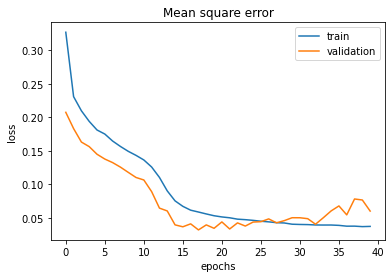

In [6]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
# plt.ylim(0, 0.6)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [7]:
# load the model
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')

In [8]:
y_test = np.array(dftest['thickness'])
test_data = (dftest - mean) / std
y_pred = model.predict(np.array(test_data.drop('thickness', axis='columns')))
y_pred = np.reshape(y_pred * std['thickness'] + mean['thickness'], y_test.shape)
print('The rmse of prediction is:', mean_squared_error(dftest['thickness'], y_pred) ** 0.5)

The rmse of prediction is: 10.832248355609433
